# Medicare Fraud Detection

### Data 698: Data Science Research Project - Spring 2019

### Student: Chunhui Zhu

Medicare_Provider_Utilization_and_Payment_Data__Physician_and_Other_Supplier_PUF_CY2016.csv: https://data.cms.gov/Medicare-Physician-Supplier/Medicare-Provider-Utilization-and-Payment-Data-Phy/utc4-f9xp

LEIE2019.csv: https://oig.hhs.gov/exclusions/exclusions_list.asp

## Continouse from Part IV

In [17]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib as plt
import pickle
from math import isnan

from sklearn.linear_model import LogisticRegression
import xgboost

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import preprocessing

from sklearn.metrics import classification_report

### Obsert from last step "convt2016_pickle"

In [18]:
df_pkl=open("convt2016_pickle","rb")
convt2016df=pickle.load(df_pkl)
df_pkl.close()

In [19]:
convt2016df.head()

,npi,type,hcpcs_c,line_srvc_cnt,bene_unique_cnt,bene_day_srvc_cnt,avg_allowed_amt,avg_payment_amt,avg_submitted_chrg_amt,city,state,Fraud
1,1003000126,0.0,99217,57.0,55.0,57.0,72.743158,54.474386,325.157895,3,2,0
2,1003000126,0.0,99219,38.0,38.0,38.0,135.010000,105.850000,614.000000,3,2,0
3,1003000126,0.0,99220,23.0,23.0,23.0,189.239565,146.116522,769.347826,3,2,0
4,1003000126,0.0,99221,20.0,20.0,20.0,100.750000,78.990000,460.000000,3,2,0
5,1003000126,0.0,99222,96.0,87.0,96.0,136.250000,105.477604,625.000000,3,2,0


## Prepare for Training set and Test set

### Use 2012-2015 as training data set, 2016 as testing data set

In [20]:
#example pickle name df13_pickle
def loadconvtdata (year):
    y=str(year)
    convt_pkl=open("convt"+str(year)+"_pickle","rb")
    convt_df=pickle.load(convt_pkl)
    print("The number of raw data in " + y +" is " + str(len(convt_df)) + ".")
    convt_pkl.close()
    
    print("Broke down fraud and non-fraud data set.")
    convt_fraud_0 = convt_df[convt_df['Fraud'] == 0]
    convt_fraud_1 = convt_df[convt_df['Fraud'] == 1]
    return (convt_fraud_0, convt_fraud_1)


In [24]:
fraud2016_0, fraud2016_1, =loadconvtdata(2016)
fraud2015_0, fraud2015_1, =loadconvtdata(2015)
fraud2014_0, fraud2014_1, =loadconvtdata(2014)
fraud2013_0, fraud2013_1, =loadconvtdata(2013)
fraud2012_0, fraud2012_1, =loadconvtdata(2012)

The number of raw data in 2016 is 7776378.
Broke down fraud and non-fraud data set.
The number of raw data in 2015 is 8817549.
Broke down fraud and non-fraud data set.
The number of raw data in 2014 is 8725103.
Broke down fraud and non-fraud data set.
The number of raw data in 2013 is 8700666.
Broke down fraud and non-fraud data set.
The number of raw data in 2012 is 8608644.
Broke down fraud and non-fraud data set.


In [42]:
fraud2012to2015_0= [fraud2015_0,fraud2014_0,fraud2013_0,fraud2012_0]
df_fraud2012to2015_0=pd.concat(fraud2012to2015_0)
print(len(df_fraud2012to2015_0))

34814662


In [43]:
fraud2012to2015_1= [fraud2015_1,fraud2014_1,fraud2013_1,fraud2012_1]
df_fraud2012to2015_1=pd.concat(fraud2012to2015_1)
print(len(df_fraud2012to2015_1))

37300


### Exclude 2016 fraud data from 2012-2015 fraud training set

In [44]:
df_fraud2012to2015_1_only=df_fraud2012to2015_1[~df_fraud2012to2015_1.npi.isin(fraud2016_1.npi.unique())]
len(df_fraud2012to2015_1_only)

23182

#### Drop "npi" & "hcpcs_c"

In [45]:
df_fraud2012to2015_1_only=df_fraud2012to2015_1_only.drop(['npi','hcpcs_c'],axis=1)
df_fraud2012to2015_0=df_fraud2012to2015_0.drop(['npi','hcpcs_c'],axis=1)
test_2016 = convt2016df.drop(['npi', 'hcpcs_c'],axis=1)

In [46]:
train_2012to2015 = pd.concat([df_fraud2012to2015_1_only,df_fraud2012to2015_0])
len(train_2012to2015)

34837844

Fraud 0: 34814662
Fraud 1: 23182
Proportion: 1501.8 : 1


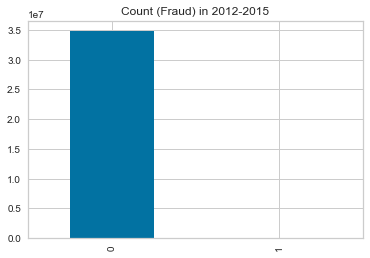

In [47]:
fraud_count = train_2012to2015.Fraud.value_counts()
print('Fraud 0:', fraud_count[0])
print('Fraud 1:', fraud_count[1])
print('Proportion:', round(fraud_count[0] / fraud_count[1], 2), ': 1')

fraud_count.plot(kind='bar', title='Count (Fraud) in 2012-2015');

## Sampling

### Random under-sampling

In [49]:
# Class count
train_fraud_0 = len(df_fraud2012to2015_0)
train_fraud_1 = len(df_fraud2012to2015_1_only)

Random under-sampling:
1    23182
0    23182
Name: Fraud, dtype: int64


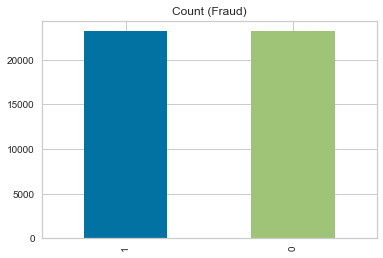

In [50]:
under_train_fraud_0 = df_fraud2012to2015_0.sample(train_fraud_1)
under_train_2012to2015 = pd.concat([under_train_fraud_0, df_fraud2012to2015_1_only], axis=0)

print('Random under-sampling:')
print(under_train_2012to2015.Fraud.value_counts())

under_train_2012to2015.Fraud.value_counts().plot(kind='bar', title='Count (Fraud)');

### Random over-sampling

Random over-sampling:
1    34814662
0    34814662
Name: Fraud, dtype: int64


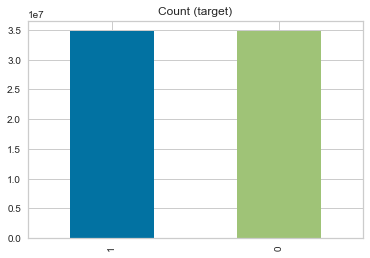

In [51]:
over_train_fraud_1 = df_fraud2012to2015_1_only.sample(train_fraud_0, replace=True)
train_over_2012to2015 = pd.concat([df_fraud2012to2015_0, over_train_fraud_1], axis=0)

print('Random over-sampling:')
print(train_over_2012to2015.Fraud.value_counts())

train_over_2012to2015.Fraud.value_counts().plot(kind='bar', title='Count (target)');

## Python imbalanced-learn module

In [53]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from imblearn.over_sampling import SMOTE

In [77]:
df_train_2012to2015=pd.concat([df_fraud2012to2015_1_only,df_fraud2012to2015_0],axis=0)

#ramdom shuffle all rows using sample()
df_train_2012to2015=df_train_2012to2015.sample( frac = 1 )

x_train=df_train_2012to2015.drop(['Fraud'],axis = 1)
y_train=df_train_2012to2015[['Fraud']]

sm = SMOTE(random_state=12, ratio = 1.0)
x_train_resample, y_train_resample = sm.fit_sample(x_train,y_train)

MemoryError: 

### Random Forest 

In [58]:
clf_rf = RandomForestClassifier(n_estimators = 25, random_state = 12)
clf_rf.fit(x_train, y_train)

C:\Users\czhu5\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=None,
            oob_score=False, random_state=12, verbose=0, warm_start=False)

In [1]:
#test_2016_1msample = test_2016.sample(1000000, replace=True)
test_2016_rand=test_2016.sample(frac = 1)
x_test_2016 = test_2016_rand.drop(['Fraud'],axis=1)
y_test_2016 = test_2016_rand[['Fraud']]

NameError: name 'test_2016' is not defined

In [70]:
pred_y=clf_rf.predict( x_test_2016 )

In [71]:
len(pred_y)

7776378

In [72]:
print( "Validation Results" )
print(clf_rf.score(x_test_2016, y_test_2016 ))
print(recall_score(y_test_2016, pred_y))

Validation Results
0.9996763274624767
0.0


In [73]:
print ( 'Test Results' )
print ( clf_rf.score( x_test_2016, y_test_2016 ))
print ( recall_score( y_test_2016, pred_y))

Test Results
0.9996763274624767
0.0


Confusion matrix:
 [[7773861      18]
 [   2499       0]]


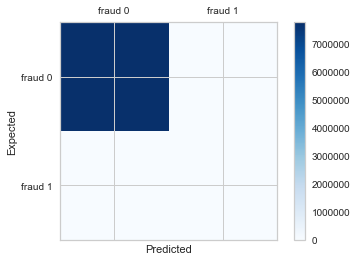

In [75]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

conf_matrix = confusion_matrix(y_true=y_test_2016, y_pred=pred_y)
print('Confusion matrix:\n', conf_matrix)

labels = ['fraud 0', 'fraud 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_matrix, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

## Reference

1. The imbalanced-learn documentation:
http://contrib.scikit-learn.org/imbalanced-learn/stable/index.html

2. Comparison of the combination of over- and under-sampling algorithms:
http://contrib.scikit-learn.org/imbalanced-learn/stable/auto_examples/combine/plot_comparison_combine.html

3. Resampling strategies for imbalanced datasets
https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets

4. The Right Way to Oversample in Predictive Modeling
https://beckernick.github.io/oversampling-modeling/